# Detecting Vehicle on Road

I wonder how driverless cars navigate on road how they detect the situation and decide what to do. So the idea is how we can have a basic model which can be used for object detection if we want to design a driverless car module. Here, it is very basic implementation but we can make it mature to that it can detect on road objects, vehicle, living being, turns or any other hazardous situations. I have used Jeremy's code as inspiration but I have tried to make it more usable to various situations e.g: if you have already downloaded images for one situation and it is in same folder where you are going to download new situation images then in one got it will learn all the cases no matter how many times you update the string. It will keep learning unless you manually delete the old data.

#### Instal if duckduckgo_search isn't available

In [1]:
!pip install duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Importing Dependencies

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import L, Path
from fastdownload import download_url
from fastai.vision.all import Image, resize_images, verify_images, get_image_files, DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, Resize, vision_learner, resnet18, error_rate, PILImage
from fastai.vision.utils import download_images, resize_image
from time import sleep
import os
import random

#### Function to use duckduckgo_search to download images

In [3]:
def search_images(search_term, max_limit=30):
  print(f"Searching {max_limit} image(s) for {search_term}.")
  return L(DDGS().images(search_term, )).itemgot('image')[:max_limit]

#### Function to test the downloading of image

In [4]:
def testDownload(keyword):
  dest = f"{keyword}.jpg"
  imgs = search_images(keyword, 1)
  download_url(imgs[0], dest, show_progress=False)
  img = Image.open(dest)
  img.to_thumb(250, 250).show()

#### Testing download image functionality with random rose image

Searching 1 image(s) for rose.


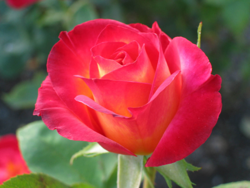

In [5]:
keyword = "rose"
testDownload(keyword)

#### Downloading another random image

Searching 1 image(s) for Daisy Flower.


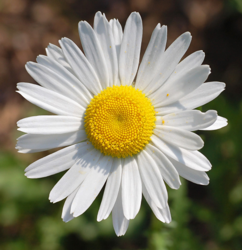

In [6]:
testDownload("Daisy Flower")

#### funtion to fetch the images from internet using DuckDuckGo for training the Model. This function will not download images repeatitively. And after every itration we take 10s break.

In [7]:
def fetch_dummy_data(items_to_search = ("rose flower", "daisy flower"), conditions = ("", "in shade", "day light photo", "side view"), path = "images_data", max_limit = 30):
  path = Path(path)

  for i in items_to_search:
    dest = (path/i)
    dest.mkdir(parents=True, exist_ok=True)
    for c in conditions:
      files_count = len([entry for entry in os.listdir(dest) if os.path.isfile(os.path.join(dest, entry))])
      max_to_download = len(conditions) * max_limit
      if files_count < max_to_download:
        download_images(dest, urls=search_images(f"{i} {c}", max_limit))
        sleep(10)
      else:
        print(f"Already enough images data in {dest} : {files_count}")
        print(f"{max_to_download} were requested to download")
    resize_images(path=dest, max_size=400, dest=dest)

#### Configurable properties to train the model

In [8]:
items_to_search = ("empty road", "vehicle on road")
conditions = ("", "in shade", "day light photo", "side view")
path = "images_data"

fetch_dummy_data(items_to_search, conditions, path)

Already enough images data in images_data/empty road : 122
120 were requested to download
Already enough images data in images_data/empty road : 122
120 were requested to download
Already enough images data in images_data/empty road : 122
120 were requested to download
Already enough images data in images_data/empty road : 122
120 were requested to download
Already enough images data in images_data/vehicle on road : 148
120 were requested to download
Already enough images data in images_data/vehicle on road : 148
120 were requested to download
Already enough images data in images_data/vehicle on road : 148
120 were requested to download
Already enough images data in images_data/vehicle on road : 148
120 were requested to download


#### This is just a failsafe code to delete downloaded images from here only.

In [9]:
# Uncomment if you want to clear downloaded data
# deleteAll = get_image_files(Path('images_data_temp'))
# deleteAll.map(Path.unlink)

#### Fastai's verify_images is function used to check if the image is openable or a valid image else we delete it. Afterall, if we can't see a image what's use we have of it.

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

FastAi's function to setup the train the model. traintest split resixing images before feeding to model wherything is being done here.

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(Path(path), bs=32)

Checking the Batches created. Keep in mind its not predictions. It's Supervised Learning so showing random data with dependend category. This is like pandas' dataframe.sample(n=12)

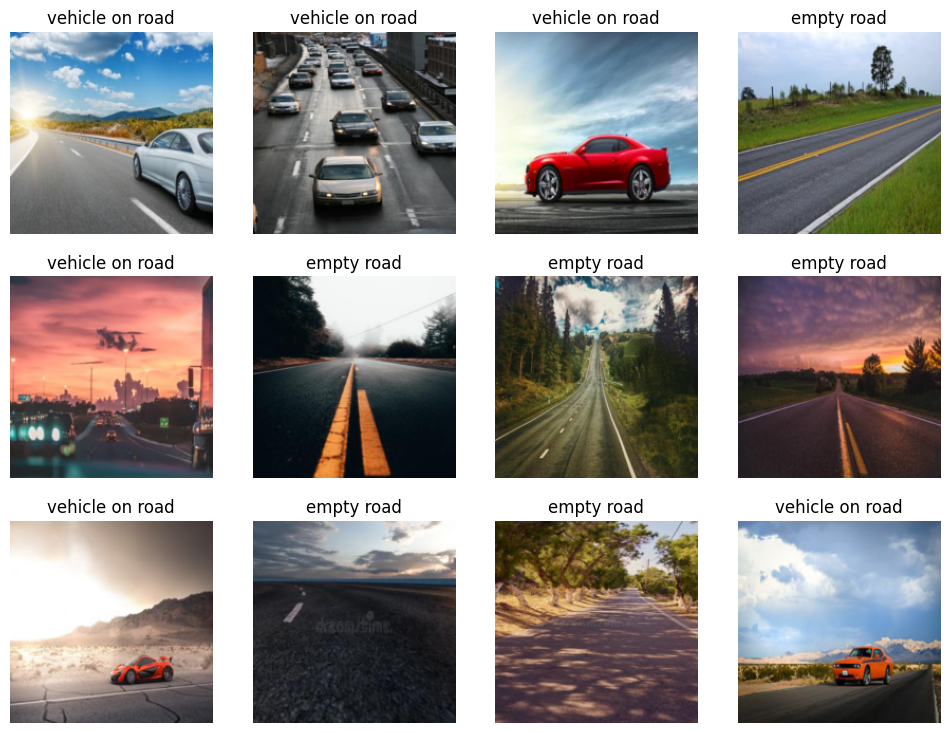

In [12]:
dls.show_batch(max_n=12)

#### So here model is learning from the feeded data.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.940771,0.387047,0.132075,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.225571,0.175425,0.075472,00:40
1,0.141451,0.101345,0.037736,00:43
2,0.117036,0.081902,0.037736,00:40


#### Function to check if the provided images is predicted correctly. Validating the model visualy.

In [14]:
def prediction_on_new_image(filename):
  is_detected,_,probs = learn.predict(PILImage.create(filename))
  print(f"This is a: {is_detected}.")
  print(list(probs))
  img = Image.open(filename)
  img.to_thumb(250, 250).show()

This is a: empty road.
[tensor(0.9998), tensor(0.0002)]


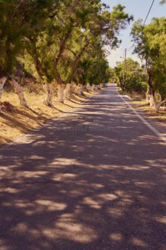

This is a: vehicle on road.
[tensor(0.0207), tensor(0.9793)]


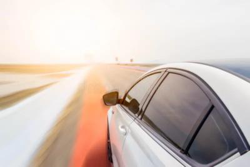

In [15]:
for i in items_to_search:
  files = get_image_files(Path(f'images_data/{i}'))
  files_count = len(files)
  img_to_predict = random.randint(0, files_count-1)
  prediction_on_new_image(files[img_to_predict])

#### Although, Model is well trained and almost 100% of the time did good prediction but when we feed random non related image data it fails. Or we can say it just check the best suited probality and say its that one only because it knows about the things it is trained for.

This is a: vehicle on road.
[tensor(0.0456), tensor(0.9544)]


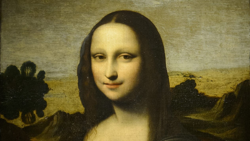

In [16]:
#Wrong prediction on totaly unrelated image
prediction_on_new_image('mona.jpg')

This is a: vehicle on road.
[tensor(0.3733), tensor(0.6267)]


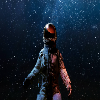

In [17]:
#Wrong prediction on totaly unrelated image
prediction_on_new_image('100x100.png')